In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from utils import *

# Import the forests data set

In [2]:
dataset_folder = './data/'
data = load_dataset(dataset_folder, 'forest')
Y_total = data['Y']
Yhat_total = data['Yhat']

# Problem setup

In [3]:
alpha = 0.1
n_total = Y_total.shape[0] # Total number of labeled examples
ns = np.linspace(50,500,10).astype(int) # Test for different numbers of labeled examples
num_trials = 50

# True mean (computed on all labels)
true_theta = Y_total.mean()

# Construct intervals

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[n:]
        
        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)
        
        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)
        
        # Append results
        results += [pd.DataFrame([{
            "method": "PPI",
            "n": n,
            "lower": ppi_ci[0],
            "upper": ppi_ci[1],
            "trial": j,
        }])]
        results += [pd.DataFrame([{
            "method": "Classical",
            "n": n,
            "lower": classical_ci[0],
            "upper": classical_ci[1],
            "trial": j,
        }])]
        
# Imputed CI
imputed_ci = classical_mean_ci(Yhat_total > 0.5, alpha=alpha)
results += [pd.DataFrame([{
    "method": "Imputation",
    "n": np.nan,
    "lower": imputed_ci[0],
    "upper": imputed_ci[1],
    "trial": 0,
}])]

df = pd.concat(results,axis=0,ignore_index=True)
df['width'] = df['upper'] - df['lower']

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 40.13it/s]


# Plot results

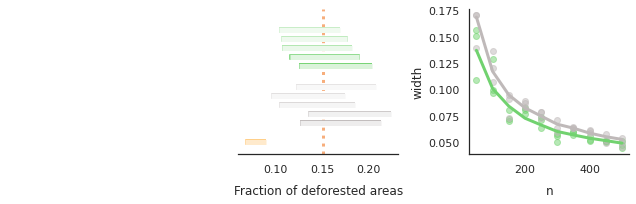

In [6]:
make_plots(df, './plots/forest.pdf', n_idx=3, intervals_xlabel="Fraction of deforested areas", true_theta=true_theta)